In [2]:
%run /Users/denis/Documents/Projects/scripts/init.ipy
os.chdir(os.getcwd().replace('/pipeline/notebooks', ''));

### 1. Get gene biotype

In [3]:
biotype_dataframe = pd.read_table('./rawdata.dir/gene_biotypes.txt', index_col='Gene name').rename(columns={'Gene type': 'gene_type'})
biotype_dataframe.head()

gene_type
Gene name           
MIR4723        miRNA
RF00019     misc_RNA
RF02116     misc_RNA
MIR6085        miRNA
RNU6-1328P     snRNA

### 2. Get annotations

In [4]:
def readGMT(infile):
    gmt = {}
    with open(infile) as openfile:
        for line in openfile.read().split('\n'):
            split_line = line.strip().split('\t')
            if split_line[0]:
                gmt[split_line[0]] = [x.split(',')[0] for x in split_line[2:]]
    return gmt

In [40]:
# Calculate
calculate = False

# Check if calculate
if calculate:
    # Get GMT
    gmt_files = glob.glob('./libraries.dir/*.txt')

    # Read GMTs
    libraries = {os.path.basename(gmt_file)[:-len('.txt')]: readGMT(gmt_file) for gmt_file in gmt_files}
    libraries_merged = {library_name: [gene for term_genes in gmt.values() for gene in term_genes] for library_name, gmt in libraries.items()}

    # Get counts
    gmt_counts = {library_name: {gene: genes_merged.count(gene) for gene in gene_count_dataframe.index} for library_name, genes_merged in libraries_merged.items()}

    # Convert to dataframe
    gmt_count_dataframe = pd.DataFrame(gmt_counts)
    
    # Write
    gmt_count_dataframe.to_csv('./rawdata.dir/gmt_counts_new.txt', sep='\t')
else:
    # Read
    gmt_count_dataframe = pd.read_table('./rawdata.dir/gmt_counts_new.txt', index_col='Unnamed: 0')

print(gmt_count_dataframe.shape)
gmt_count_dataframe.head()

(23568, 15)


GO_Molecular_Function_2018  ARCHS4_TFs_Coexp  huMAP  Reactome_2016  \
A1BGAS1                           0                 0      0              0   
A1CF                              2                26      0              1   
A2M                               6                16      0             16   
A2ML1                             1                18      0              0   
A2MP1                             0                 4      0              0   

         WikiPathways_2016  ARCHS4_Kinases_Coexp  KEGG_2016  \
A1BGAS1                  0                     0          0   
A1CF                     0                     6          0   
A2M                      1                    11          1   
A2ML1                    0                     3          0   
A2MP1                    0                     0          0   

         GO_Biological_Process_2018  MGI_Mammalian_Phenotype_Level_4  SCP  \
A1BGAS1                           0                                0    0   
A1CF                              3                                2    4   
A2M                               8                                0    4   
A2ML1                             2                                0    1   
A2MP1                             0                                0    0   

         GO_Cellular_Component_2018  LINCS_L1000_Kinase_Perturbations_down  \
A1BGAS1                           0                                      0   
A1CF                              0                                     60   
A2M                               3                                     37   
A2ML1                             0                                      0   
A2MP1                             0                                      0   

         ChEA_2016  LINCS_L1000_Kinase_Perturbations_up  \
A1BGAS1          0                                    0   
A1CF            29                                    9   
A2M             23                                   33   
A2ML1           22                                    0   
A2MP1            0                                    0   

         ENCODE_TF_ChIPseq_2015  
A1BGAS1                       0  
A1CF                          7  
A2M                          27  
A2ML1                        15  
A2MP1                         5

In [41]:
# Get library counts
library_count_dataframe = gmt_count_dataframe.apply(lambda x: sum([y > 0 for y in x]), axis=1).rename('libraries').to_frame()
library_count_dataframe.head()

libraries
A1BGAS1          0
A1CF            11
A2M             13
A2ML1            7
A2MP1            2

### 3. Merge

In [37]:
plot_dataframe = library_count_dataframe.merge(biotype_dataframe, left_index=True, right_index=True)
plot_dataframe['pseudogene'] = ['pseudogene' in x for x in plot_dataframe['gene_type']]
print(plot_dataframe.shape)
plot_dataframe.head()

(24002, 3)


libraries                           gene_type  pseudogene
A1CF            11                      protein_coding       False
A2M             13                      protein_coding       False
A2ML1            7                      protein_coding       False
A2MP1            2  transcribed_unprocessed_pseudogene        True
A3GALT2          6                      protein_coding       False

### 4. Overall Boxplot


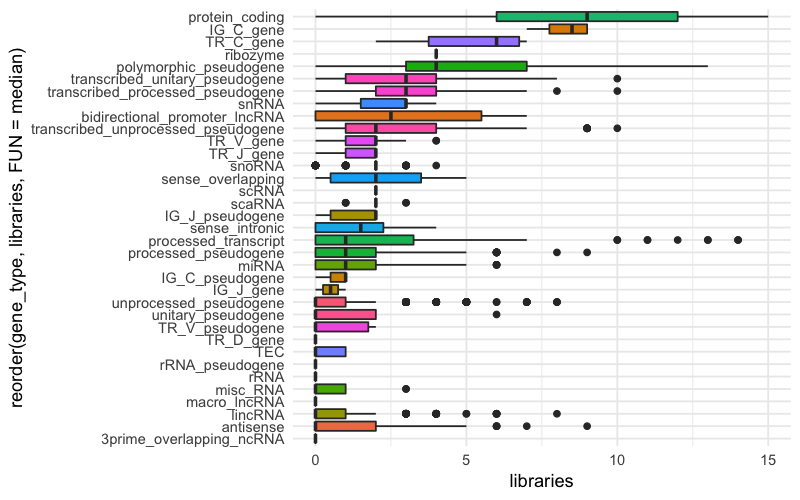

In [39]:
%%R -i plot_dataframe -h 500 -w 800 -r 120
#ticks <- seq()
ggplot(plot_dataframe, aes(x=reorder(gene_type, libraries, FUN=median), y=libraries, fill=gene_type)) +
geom_boxplot() +
#facet_wrap(~, scales='free') +
coord_flip() +
#scale_fill_gradient2(low='black', mid='yellow', high='red', trans='log10', midpoint='1') +
#scale_color_gradient2(low='black', mid='yellow', high='red', trans='log10', midpoint='1') +
#scale_x_log10() +
#scale_y_log10() +
#scale_x_continuous(lim=c(min(ticks), max(ticks)), breaks=ticks, labels=ticks, trans='log10') +
#scale_y_continuous(lim=c(min(ticks), max(ticks)), breaks=ticks, labels=ticks, trans='log10') +
#ggtitle('') +
#xlab('') +
#ylab('') +
theme_minimal() +
guides(fill=FALSE)

### 3. Library-wise boxplot

In [46]:
library_plot_dataframe = pd.melt(gmt_count_dataframe.reset_index(), id_vars='index').set_index('index').merge(biotype_dataframe, left_index=True, right_index=True).reset_index()
print(library_plot_dataframe.shape)
library_plot_dataframe.head()

(360030, 4)


index                    variable  value       gene_type
0  A1CF  GO_Molecular_Function_2018      2  protein_coding
1  A1CF            ARCHS4_TFs_Coexp     26  protein_coding
2  A1CF                       huMAP      0  protein_coding
3  A1CF               Reactome_2016      1  protein_coding
4  A1CF           WikiPathways_2016      0  protein_coding

/Users/denis/anaconda3/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning:

from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.



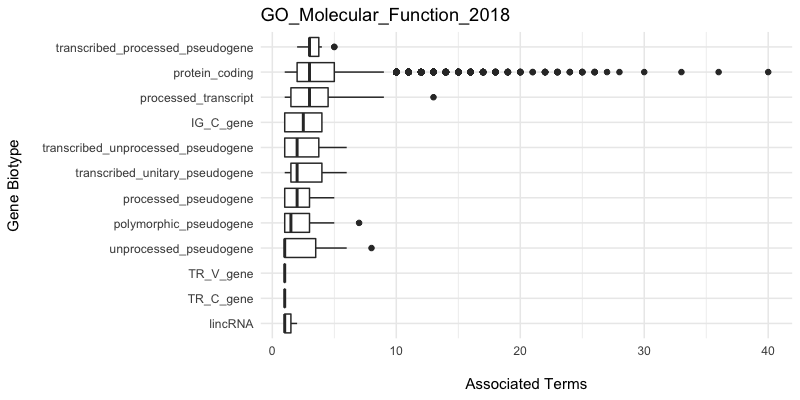

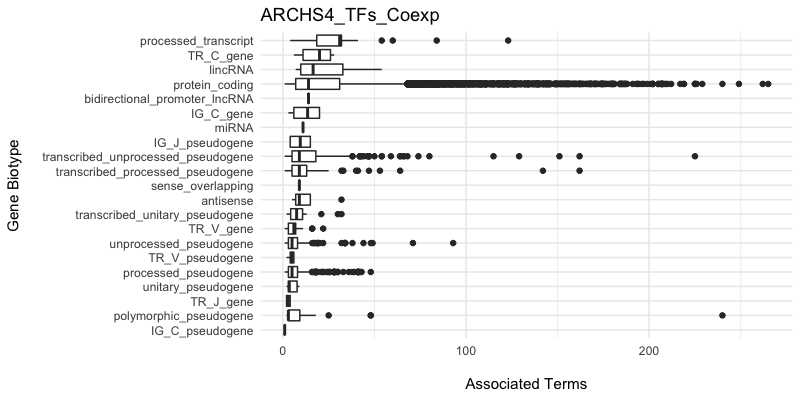

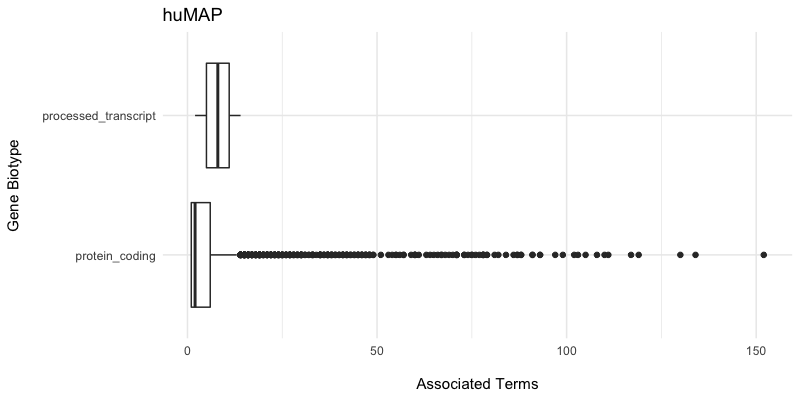

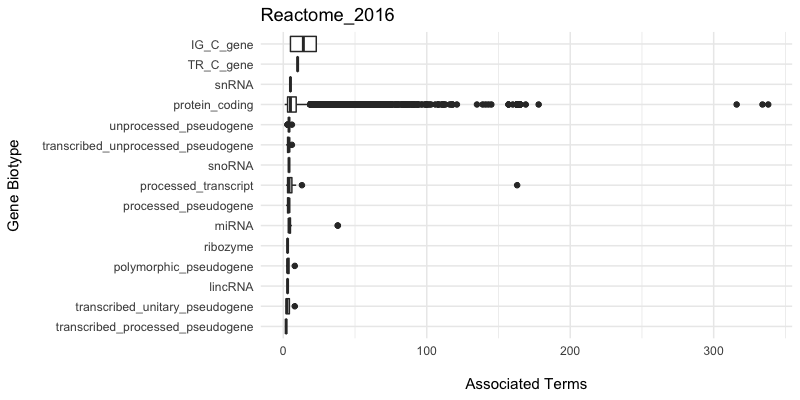

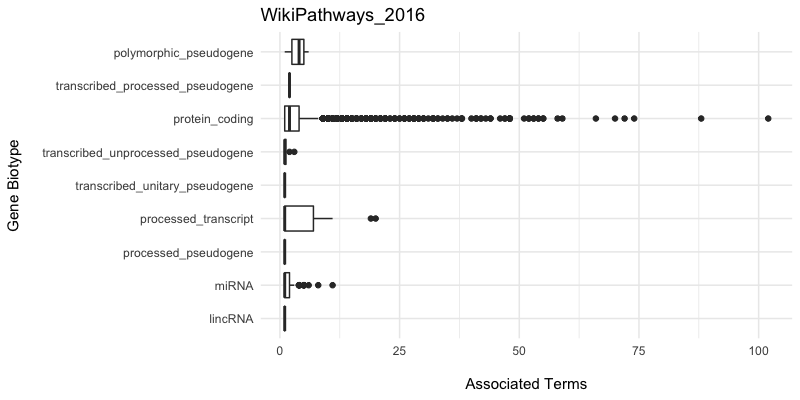

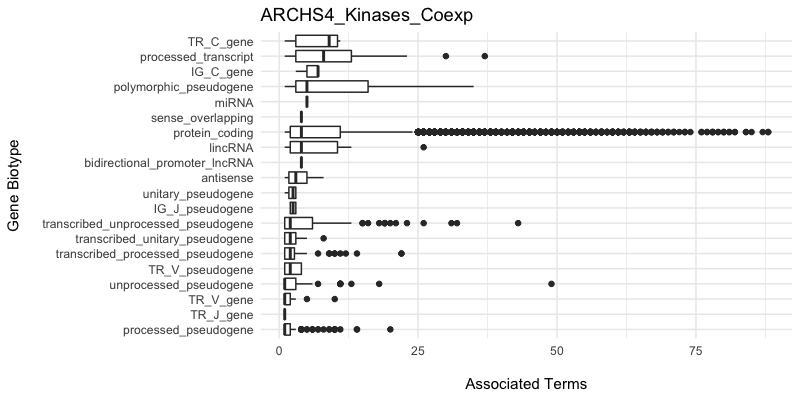

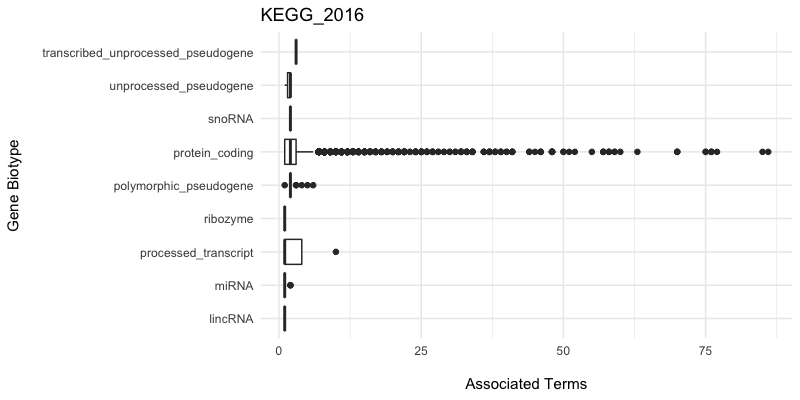

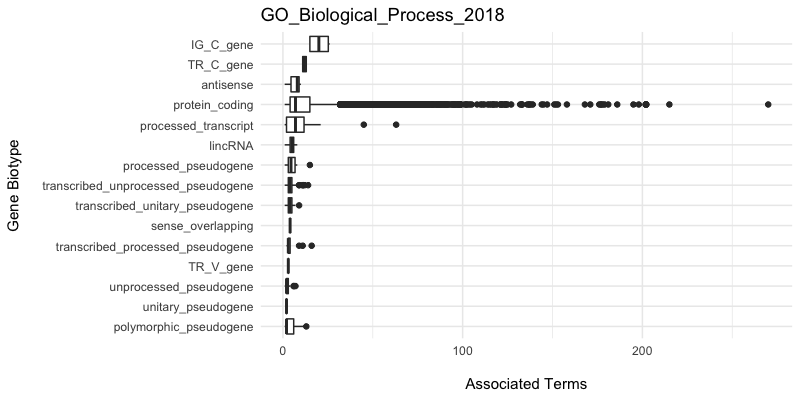

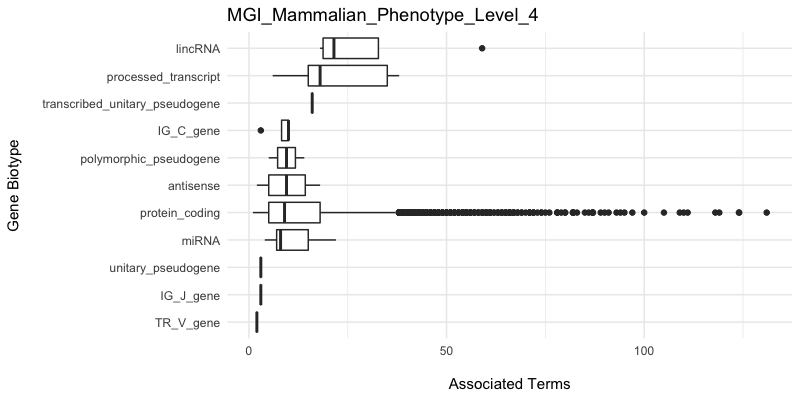

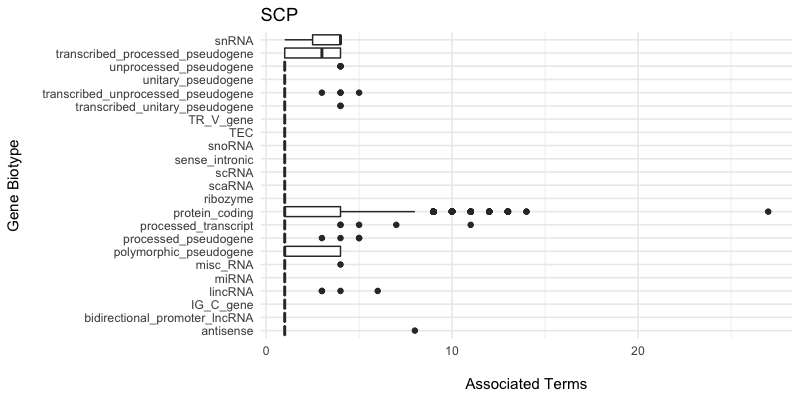

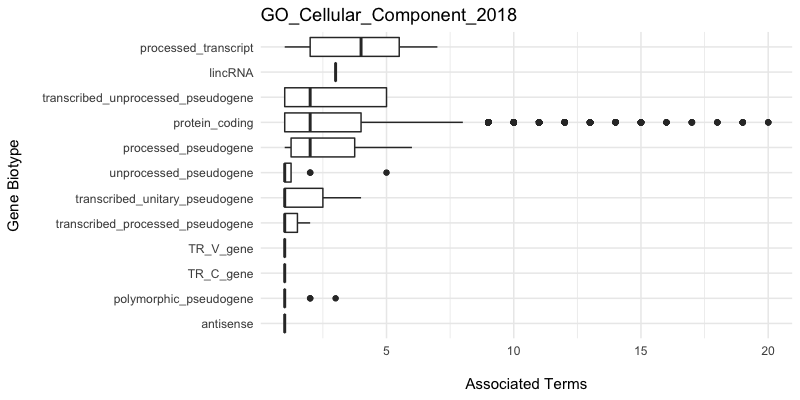

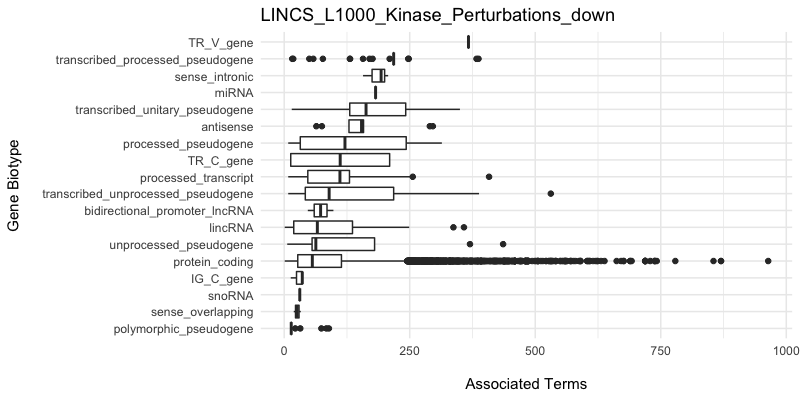

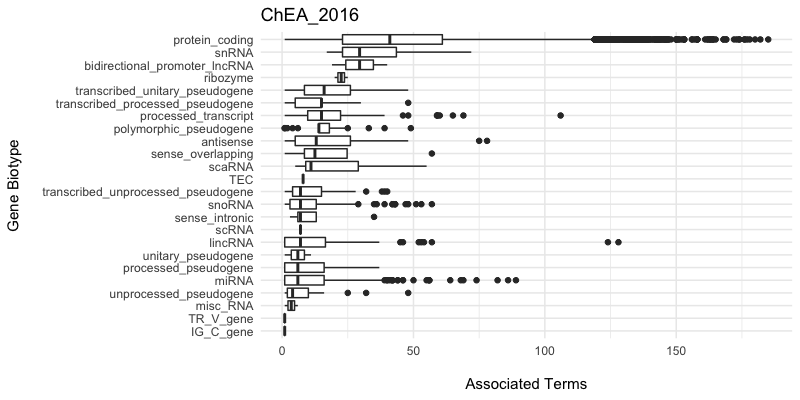

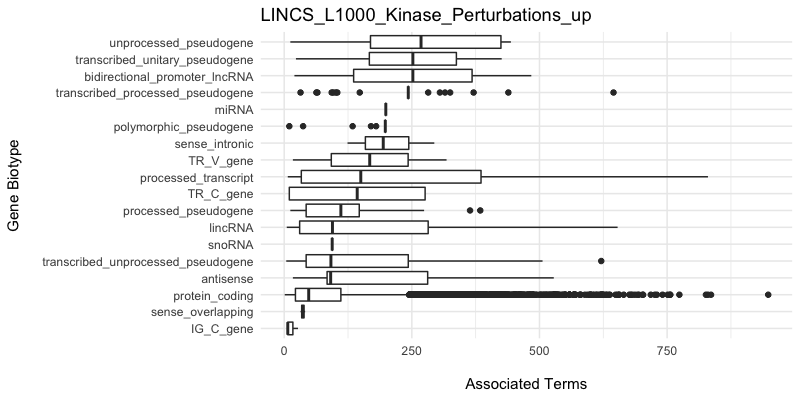

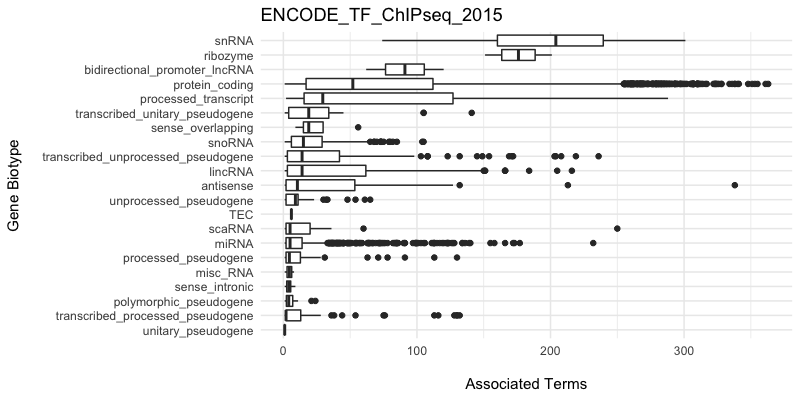

In [62]:
for library in library_plot_dataframe.variable.unique():
    library_plot_dataframe_subset = library_plot_dataframe.query('variable == "{}" and value > 0'.format(library))
    %R -h 400 -w 800 -r 100 -i library_plot_dataframe_subset,library print(ggplot(library_plot_dataframe_subset, aes(x=reorder(gene_type, value, FUN=median), y=value)) + geom_boxplot() + ggtitle(library) + theme_minimal() + coord_flip() + ylab('\nAssociated Terms') + xlab('Gene Biotype\n'))